# *Challenge 1*: A **kernel** methods / **DL** pipeline for the FashionMNIST dataset

Advanced Topics in Machine Learning -- Fall 2024, UniTS

<a target="_blank" href="https://colab.research.google.com/github/ganselmif/adv-ml-units/blob/main/notebooks/AdvML_Challenge_1.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab"/></a>


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torchvision
import torch
import torchvision.transforms as transforms
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import pdist, squareform
from numpy import exp
from scipy import linalg as LA
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, classification_report
import seaborn as sns


During this first *challenge* of the *Advanced Machine Learning Course*, you will experiment with the development of a data analysis pipeline based upon various techniques seen during the lectures so far: some **unsupervised** (*e.g.* *PCA*, *kernel-PCA*) and some others **supervised** (*e.g.* *kernel SVM* and *Artificial Neural Networks* for classification).

### The dataset

The dataset of interest for the *challenge* will be [*FashionMNIST*](https://github.com/zalandoresearch/fashion-mnist), an *MNIST*-like dataset of grayscale images of fashion items. Originally developed by Zalando Research in 2017 as a harder (yet *drop-in* compatible) replacement for the original *MNIST* dataset, it has been used in several papers and competitions since then.

Remember to consider the *dataset* mentioned below as the **training set** offered by *FashionMNIST*. Use the *test set* only at the end, to evaluate the overall accuracy of the pipeline!

### Section 1: Understanding data geometry

Load the dataset in the most suitable form for the tasks that follow. Then, perform the following steps, with the goal of developing a geometric understanding of the dataset:

1. Perform a (linear) *PCA* on the dataset, and plot the first two (or three!) principal components along with the true label. Comment on data separation.

2. Perform a *kernel-PCA* on the dataset with a Gaussian kernel, and plot the first two (or three!) principal components along with the true label. Try to tune the dispersion parameter of the kernel to obtain a good separation of the data. Comment.

3. Perform another *kernel-PCA* on the dataset with another kernel of your own choice, and plot the first two (or three!) principal components along with the true label. Try to tune the degree of the polynomial kernel to obtain a good separation of the data. Comment.

Whenever suitable, try to complement your analysis with some graphs!

**IMPORTANT NOTICE**: As some of you have reported, performing *kernel PCA* on the entire *FashionMNIST* dataset can be memory- and time- demanding (as it scales with the square of the number of datapoints!). In case you want to reduce such requirements, you can either:
  - Reduce the number of datapoints on which to perform *kPCA*, *e.g.* by slicing the randomly-shuffled dataset *(most effective!)*;
  - Reduce the size of the images in the dataset (*i.e.* by dropping even/odd rows/columns, or performing local pooling) *(somehow effective: you may want to try it if you do not have access to powerful compute, but still enjoy challenges!)*.

#### Solution 1:

##### 1.

In [273]:
# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])

# Load the training and test datasets
trainset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

# Create data loaders
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

# Display the size of the datasets
print(f'Training set size: {len(trainset)}')
print(f'Test set size: {len(testset)}')

# Get a sample of the training data
train_sample = torch.utils.data.Subset(trainset, np.random.choice(len(trainset), size=6000, replace=False))
test_sample = torch.utils.data.Subset(testset, np.random.choice(len(testset), size=2000, replace=False))
# Create a data loader for the sample
train_sample_loader = torch.utils.data.DataLoader(train_sample, batch_size=64, shuffle=True)
test_sample_loader = torch.utils.data.DataLoader(test_sample, batch_size=64, shuffle=True)


Training set size: 60000
Test set size: 10000


In [274]:
# Assuming 'train_sample' is a subset of the original 'trainset'
images, labels = [], []
for img, label in train_sample:
    images.append(img.numpy().flatten())  # Flatten images from 28x28 to 784 (for PCA)
    labels.append(label)  # Collect labels as they are

images = np.array(images)  # Shape will be (10000, 784)
labels = np.array(labels)  # Shape will be (10000,)

# Standardize the data (zero mean, unit variance)
scaler = StandardScaler()
images_scaled = scaler.fit_transform(images)

In [242]:
# Assuming 'train_sample' is a subset of the original 'trainset'
images_test, labels_test = [], []
for img, label in test_sample:
    images_test.append(img.numpy().flatten())  # Flatten images from 28x28 to 784 (for PCA)
    labels_test.append(label)  # Collect labels as they are

images_test = np.array(images_test)  # Shape will be (10000, 784)
labels_test = np.array(labels_test)  # Shape will be (10000,)

# Standardize the data (zero mean, unit variance)
scaler = StandardScaler()
images_scaled_test = scaler.fit_transform(images_test)

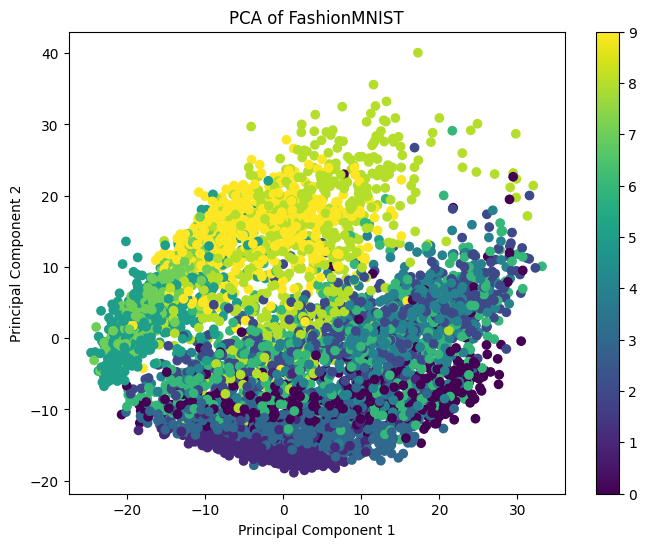

In [ ]:
# Apply PCA
pca = PCA(n_components=3)  # Choose the number of components you want to keep
principal_components = pca.fit_transform(images_scaled)

# Plot the first two principal components with labels
plt.figure(figsize=(8, 6))
plt.scatter(principal_components[:, 0], principal_components[:, 1], c=labels, cmap='viridis')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of FashionMNIST')
plt.colorbar()
plt.show()

In [ ]:
print(len(principal_components))

6000


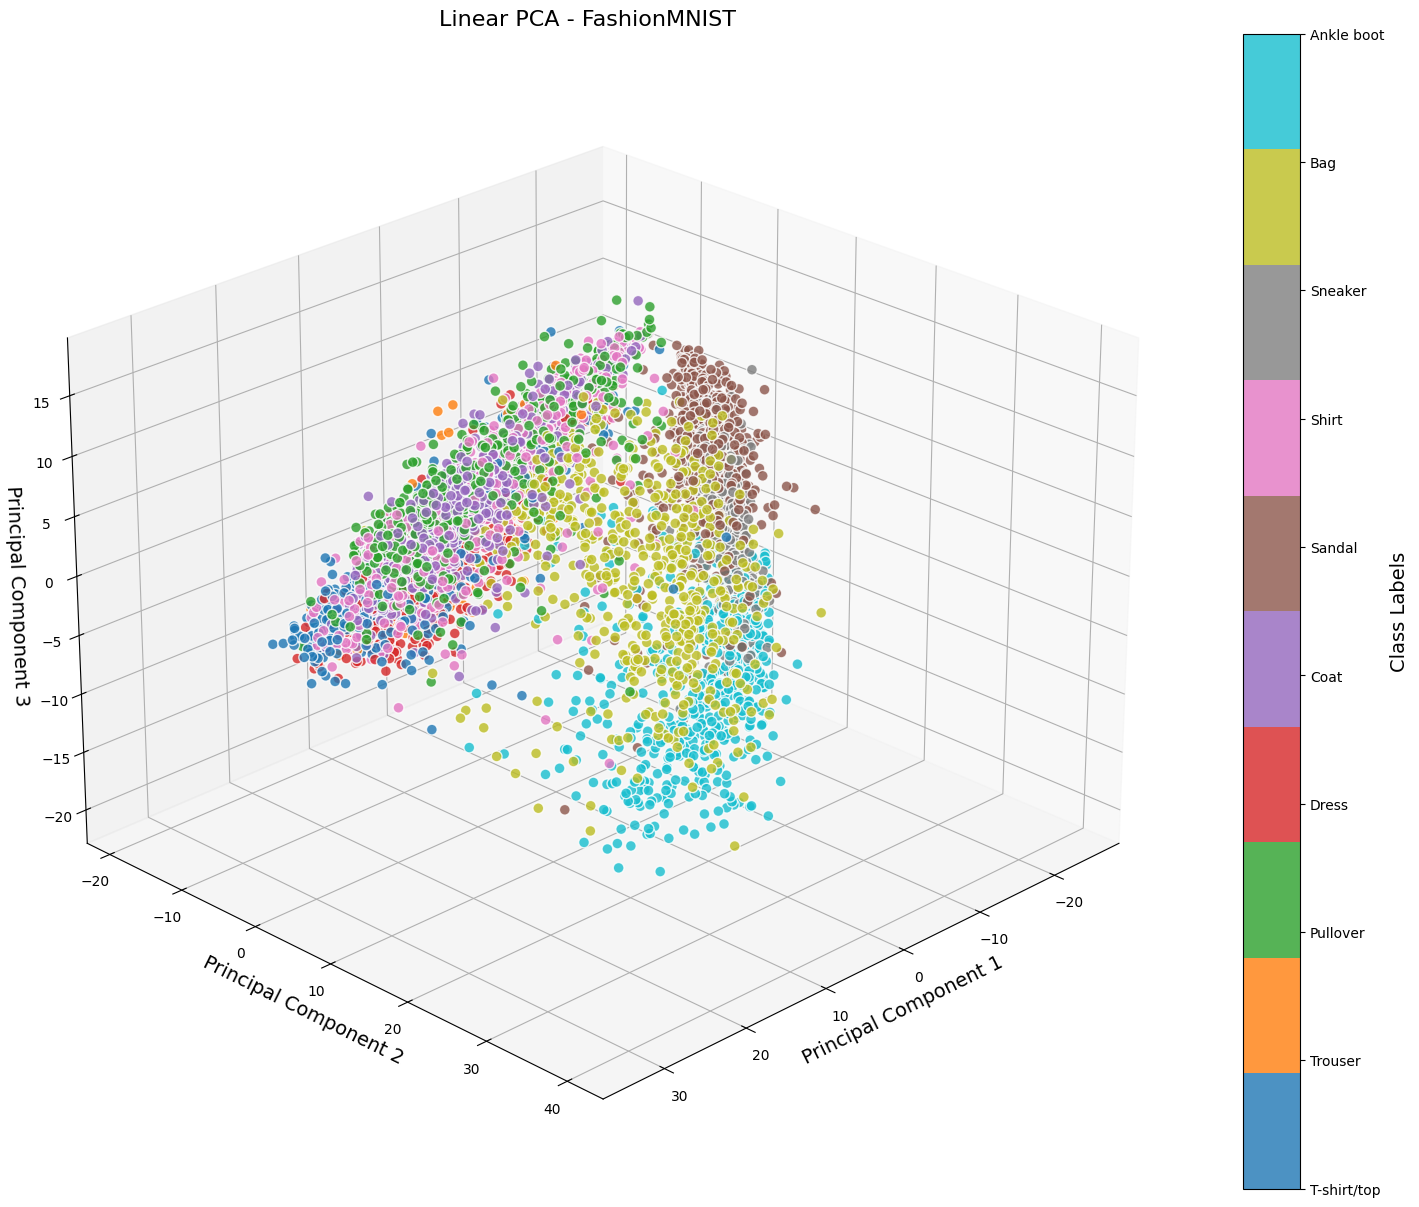

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Dizionario per mappare le etichette numeriche ai nomi delle classi
labels_dict = {
    0: 'T-shirt/top',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle boot'
}

# Supponiamo che `principal_components_gaussian` e `labels` siano già definiti
# `principal_components_gaussian` è il risultato di Kernel PCA con kernel gaussiano (RBF)
# `labels` è l'array delle etichette originali (da 0 a 9)

# Mappa le etichette numeriche nei nomi delle classi
label_names = [labels_dict[label] for label in labels]

# Impostiamo il grafico 3D
fig = plt.figure(figsize=(20, 15))
ax = fig.add_subplot(111, projection='3d')

# Usa la colormap 'tab10' per avere colori distinti per ogni classe
scatter = ax.scatter(
    principal_components[:, 0],
    principal_components[:, 1],
    principal_components[:, 2],
    c=labels, cmap='tab10', s=60, alpha=0.8, edgecolors='w', marker='o'
)

# Etichette degli assi
ax.set_xlabel('Principal Component 1', fontsize=14)
ax.set_ylabel('Principal Component 2', fontsize=14)
ax.set_zlabel('Principal Component 3', fontsize=14)

# Titolo del grafico
ax.set_title('Linear PCA - FashionMNIST', fontsize=16)

# Aggiungi una barra dei colori (colorbar) che mappi le etichette numeriche ai nomi delle classi
colorbar = plt.colorbar(scatter, ax=ax, ticks=np.arange(10))
colorbar.set_label('Class Labels', fontsize=14)
colorbar.set_ticks(np.arange(10))
colorbar.set_ticklabels([labels_dict[i] for i in range(10)])

# Impostare l'angolo di visualizzazione 3D
ax.view_init(elev=25, azim=45)

# Mostra il grafico
plt.show()


In [ ]:
# Ricostruzione dei dati utilizzando le prime 2 componenti principali
reconstructed_images = pca.inverse_transform(principal_components)

# Calcolare l'errore quadratico medio (MSE) tra i dati originali e quelli ricostruiti
mse = np.mean((images_scaled - reconstructed_images) ** 2)
print(f"Errore quadratico medio (MSE) nella ricostruzione: {mse}")


Errore quadratico medio (MSE) nella ricostruzione: 0.5806272029876709


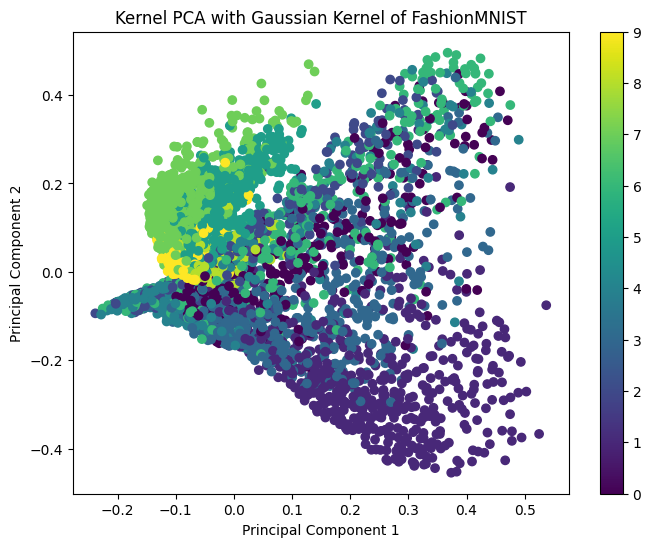

['T-shirt/top', 'Trouser', 'Coat', 'Ankle boot', 'Sneaker', 'Shirt', 'Sandal', 'Bag', 'Trouser', 'Shirt']


In [ ]:
# Apply Kernel PCA with a Gaussian kernel
kpca_gaussian_2 = KernelPCA(n_components=3, kernel='rbf', gamma=0.005, fit_inverse_transform=True)
x_gaussian = kpca_gaussian_2.fit_transform(images_scaled)

# Plot the first two principal components with labels
plt.figure(figsize=(8, 6))
plt.scatter(x_gaussian[:, 0], x_gaussian[:, 1], c=labels, cmap='viridis')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Kernel PCA with Gaussian Kernel of FashionMNIST')
plt.colorbar()
plt.show()

# Definisci il dizionario per mappare le etichette numeriche ai nomi delle classi
labels_dict = {
    0: 'T-shirt/top',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle boot'
}

# Esempio di come usare il dizionario per mappare le etichette
label_names = [labels_dict[label] for label in labels]

# Ora `label_names` conterrà i nomi delle categorie invece dei numeri
print(label_names[:10])  # Mostra le prime 10 etichette


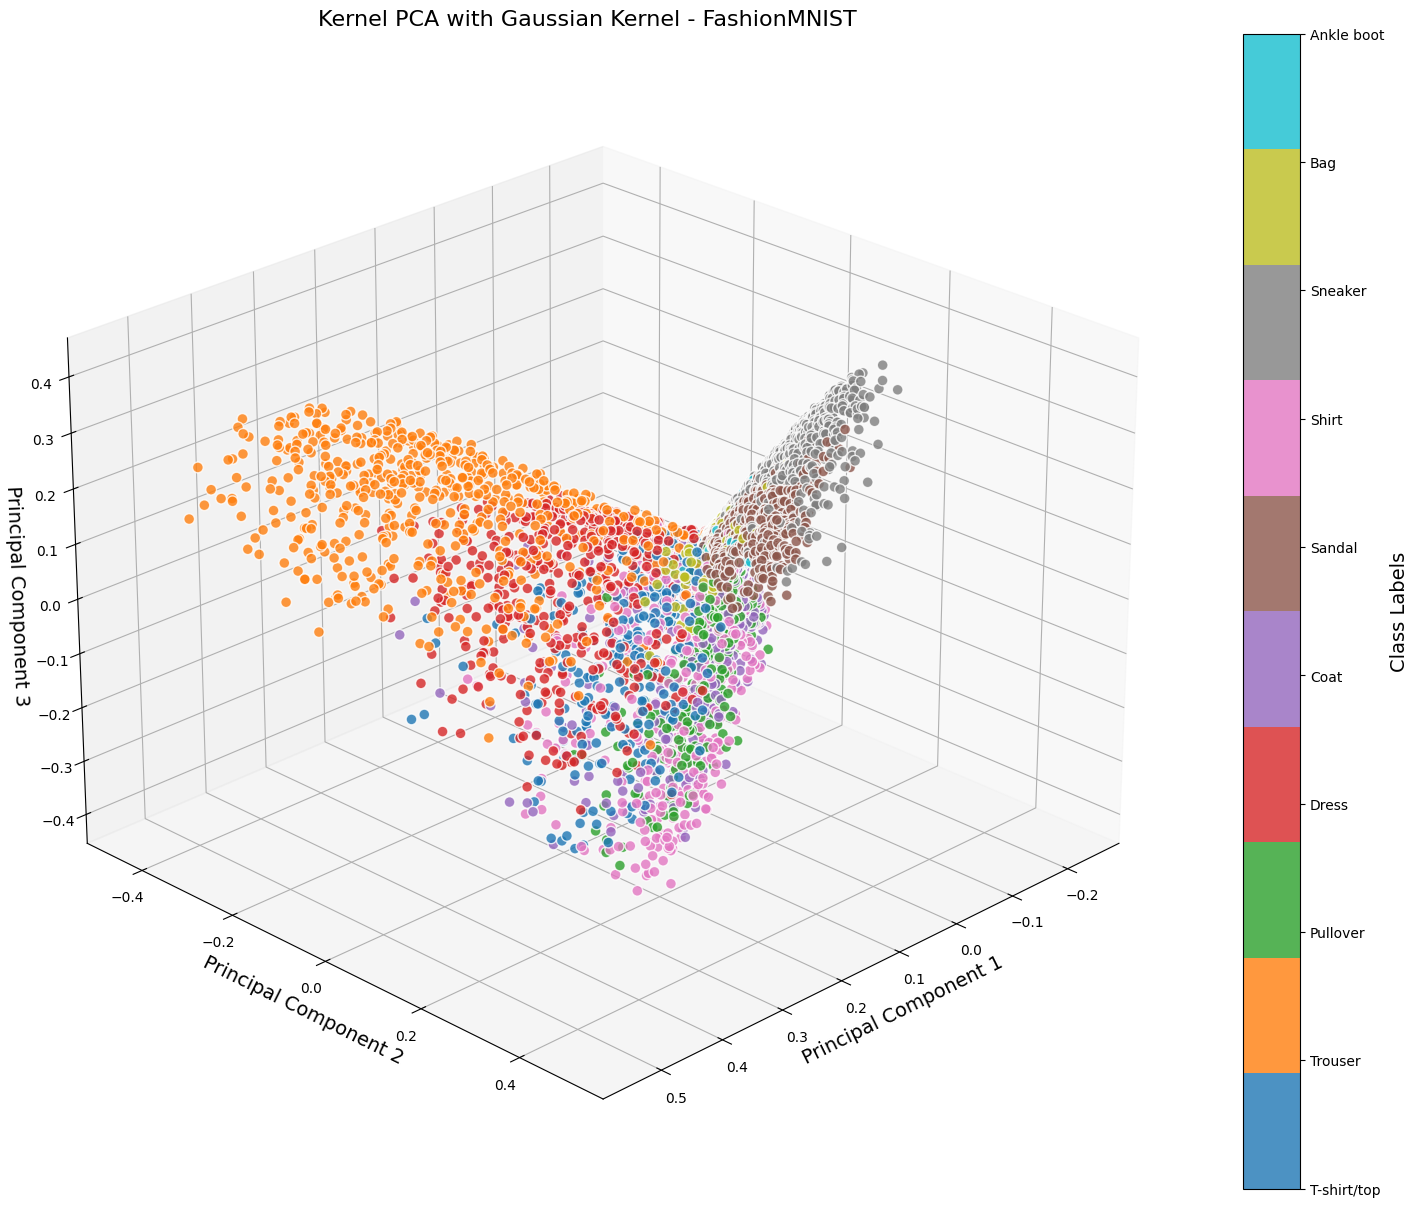

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Dizionario per mappare le etichette numeriche ai nomi delle classi
labels_dict = {
    0: 'T-shirt/top',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle boot'
}

# Supponiamo che `principal_components_gaussian` e `labels` siano già definiti
# `principal_components_gaussian` è il risultato di Kernel PCA con kernel gaussiano (RBF)
# `labels` è l'array delle etichette originali (da 0 a 9)

# Mappa le etichette numeriche nei nomi delle classi
label_names = [labels_dict[label] for label in labels]

# Impostiamo il grafico 3D
fig = plt.figure(figsize=(20, 15))
ax = fig.add_subplot(111, projection='3d')

# Usa la colormap 'tab10' per avere colori distinti per ogni classe
scatter = ax.scatter(
    x_gaussian[:, 0],
    x_gaussian[:, 1],
    x_gaussian[:, 2],
    c=labels, cmap='tab10', s=60, alpha=0.8, edgecolors='w', marker='o'
)

# Etichette degli assi
ax.set_xlabel('Principal Component 1', fontsize=14)
ax.set_ylabel('Principal Component 2', fontsize=14)
ax.set_zlabel('Principal Component 3', fontsize=14)

# Titolo del grafico
ax.set_title('Kernel PCA with Gaussian Kernel - FashionMNIST', fontsize=16)

# Aggiungi una barra dei colori (colorbar) che mappi le etichette numeriche ai nomi delle classi
colorbar = plt.colorbar(scatter, ax=ax, ticks=np.arange(10))
colorbar.set_label('Class Labels', fontsize=14)
colorbar.set_ticks(np.arange(10))
colorbar.set_ticklabels([labels_dict[i] for i in range(10)])

# Impostare l'angolo di visualizzazione 3D
ax.view_init(elev=25, azim=45)

# Mostra il grafico
plt.show()


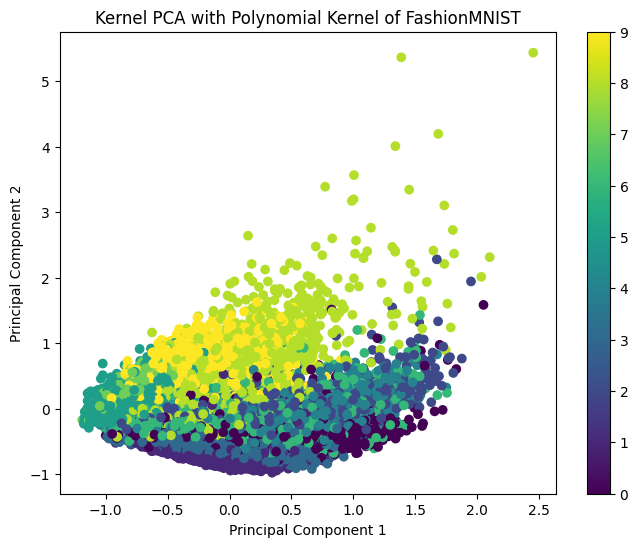

In [ ]:
##### 3.
# Apply Kernel PCA with a polynomial kernel
kpca_polynomial = KernelPCA(n_components=3, kernel='poly', degree=2)  # Tune degree
principal_components_polynomial = kpca_polynomial.fit_transform(images_scaled)

# Plot the first two principal components with labels
plt.figure(figsize=(8, 6))
plt.scatter(principal_components_polynomial[:, 0], principal_components_polynomial[:, 1], c=labels, cmap='viridis')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Kernel PCA with Polynomial Kernel of FashionMNIST')
plt.colorbar()
plt.show()

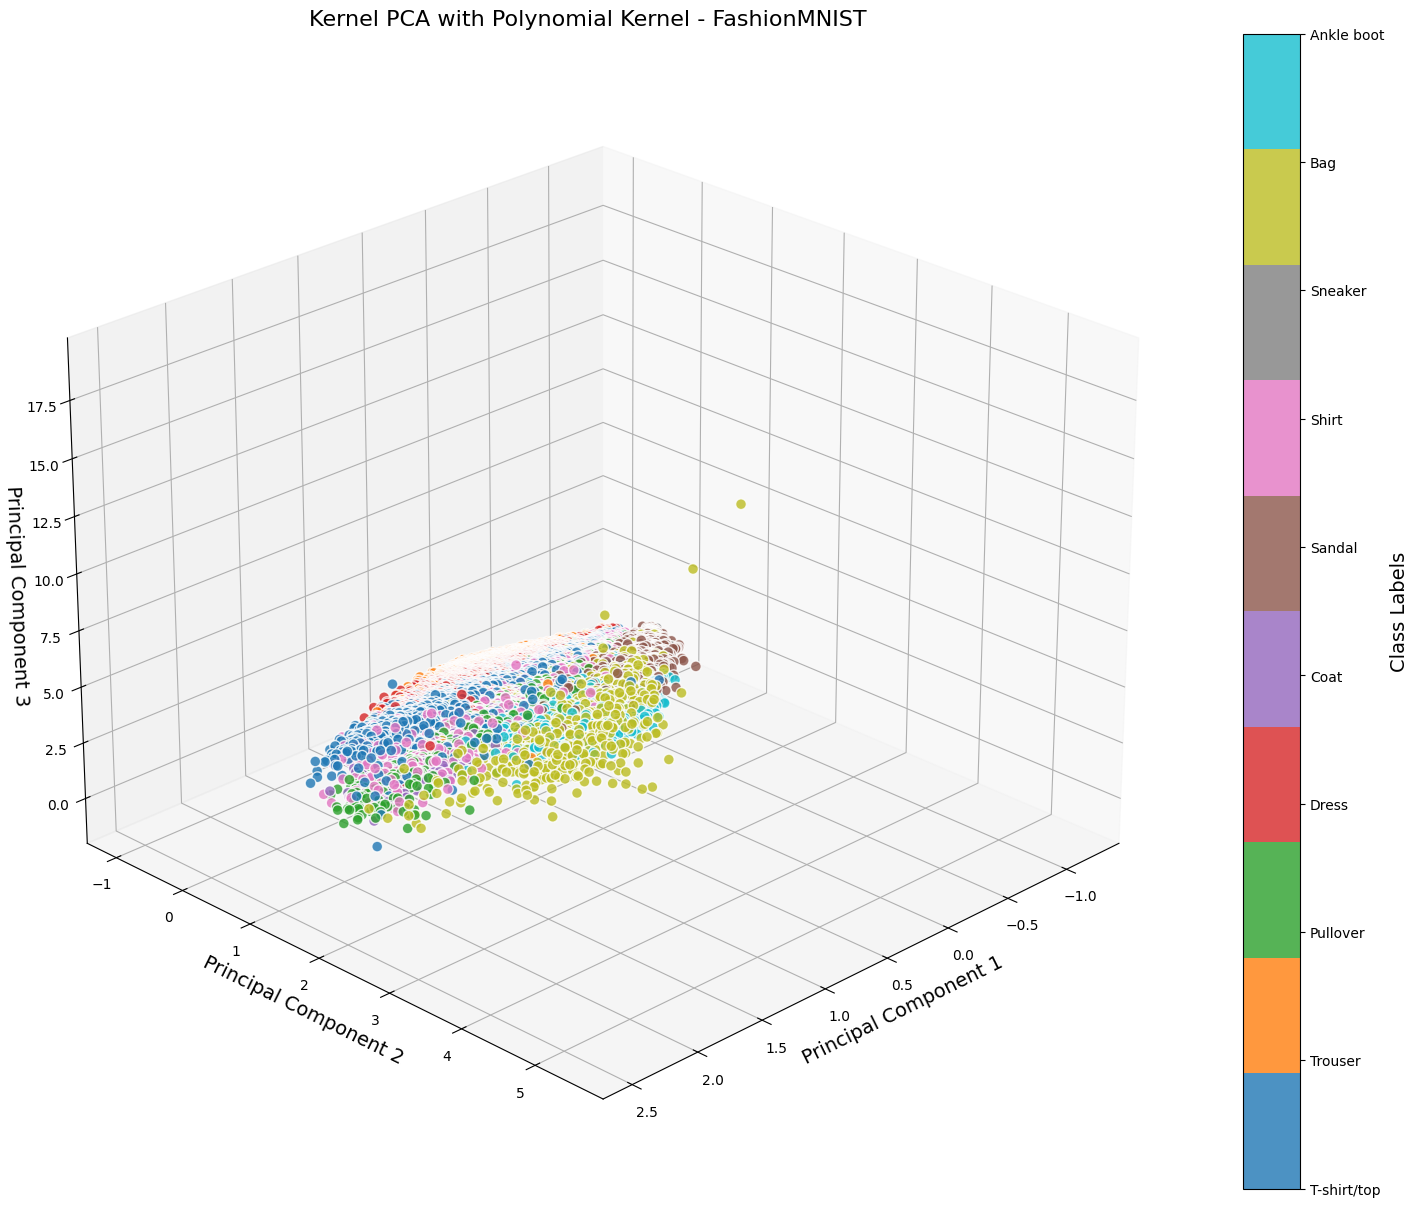

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Dizionario per mappare le etichette numeriche ai nomi delle classi
labels_dict = {
    0: 'T-shirt/top',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle boot'
}

# Supponiamo che `principal_components_gaussian` e `labels` siano già definiti
# `principal_components_gaussian` è il risultato di Kernel PCA con kernel gaussiano (RBF)
# `labels` è l'array delle etichette originali (da 0 a 9)

# Mappa le etichette numeriche nei nomi delle classi
label_names = [labels_dict[label] for label in labels]

# Impostiamo il grafico 3D
fig = plt.figure(figsize=(20, 15))
ax = fig.add_subplot(111, projection='3d')

# Usa la colormap 'tab10' per avere colori distinti per ogni classe
scatter = ax.scatter(
    principal_components_polynomial[:, 0],
    principal_components_polynomial[:, 1],
    principal_components_polynomial[:, 2],
    c=labels, cmap='tab10', s=60, alpha=0.8, edgecolors='w', marker='o'
)

# Etichette degli assi
ax.set_xlabel('Principal Component 1', fontsize=14)
ax.set_ylabel('Principal Component 2', fontsize=14)
ax.set_zlabel('Principal Component 3', fontsize=14)

# Titolo del grafico
ax.set_title('Kernel PCA with Polynomial Kernel - FashionMNIST', fontsize=16)

# Aggiungi una barra dei colori (colorbar) che mappi le etichette numeriche ai nomi delle classi
colorbar = plt.colorbar(scatter, ax=ax, ticks=np.arange(10))
colorbar.set_label('Class Labels', fontsize=14)
colorbar.set_ticks(np.arange(10))
colorbar.set_ticklabels([labels_dict[i] for i in range(10)])

# Impostare l'angolo di visualizzazione 3D
ax.view_init(elev=25, azim=45)

# Mostra il grafico
plt.show()

##### 2.

### Section 2: Bridging *unsupervised* and *supervised*

Choose one of the results obtained in the previous section (you should choose the one better explaining data geometry), and ignore the true labels. Then, perform the following steps:

1. Considering only the first $10$ components of the *(kernel-)PCA* and try to assign $10$ labels to the resulting datapoints. Choose the approach you deem most suitable. Comment on the results, by considering:
    
    a. How well does the label-assignment just performed reflect the true labels?

    b. Does the number of components used ($10$) reflect the actual *knee-* or *gap-* *point* of the spectrum associated to the principal components?

Whenever suitable, try to complement your analysis with some graphs!

In [227]:
kpca_gaussian = KernelPCA(n_components=10, kernel='rbf', gamma=0.005, fit_inverse_transform=True)
principal_components_gaussian = kpca_gaussian.fit_transform(images_scaled)

In [ ]:
print(len(principal_components_gaussian))
print(len(labels))

10000
10000


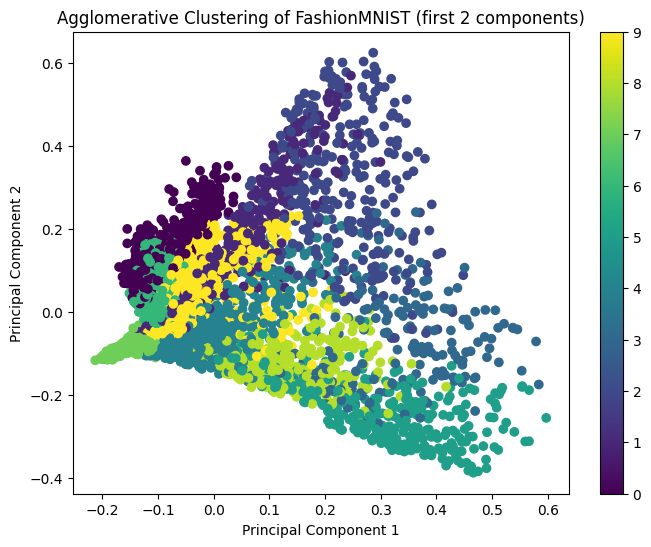

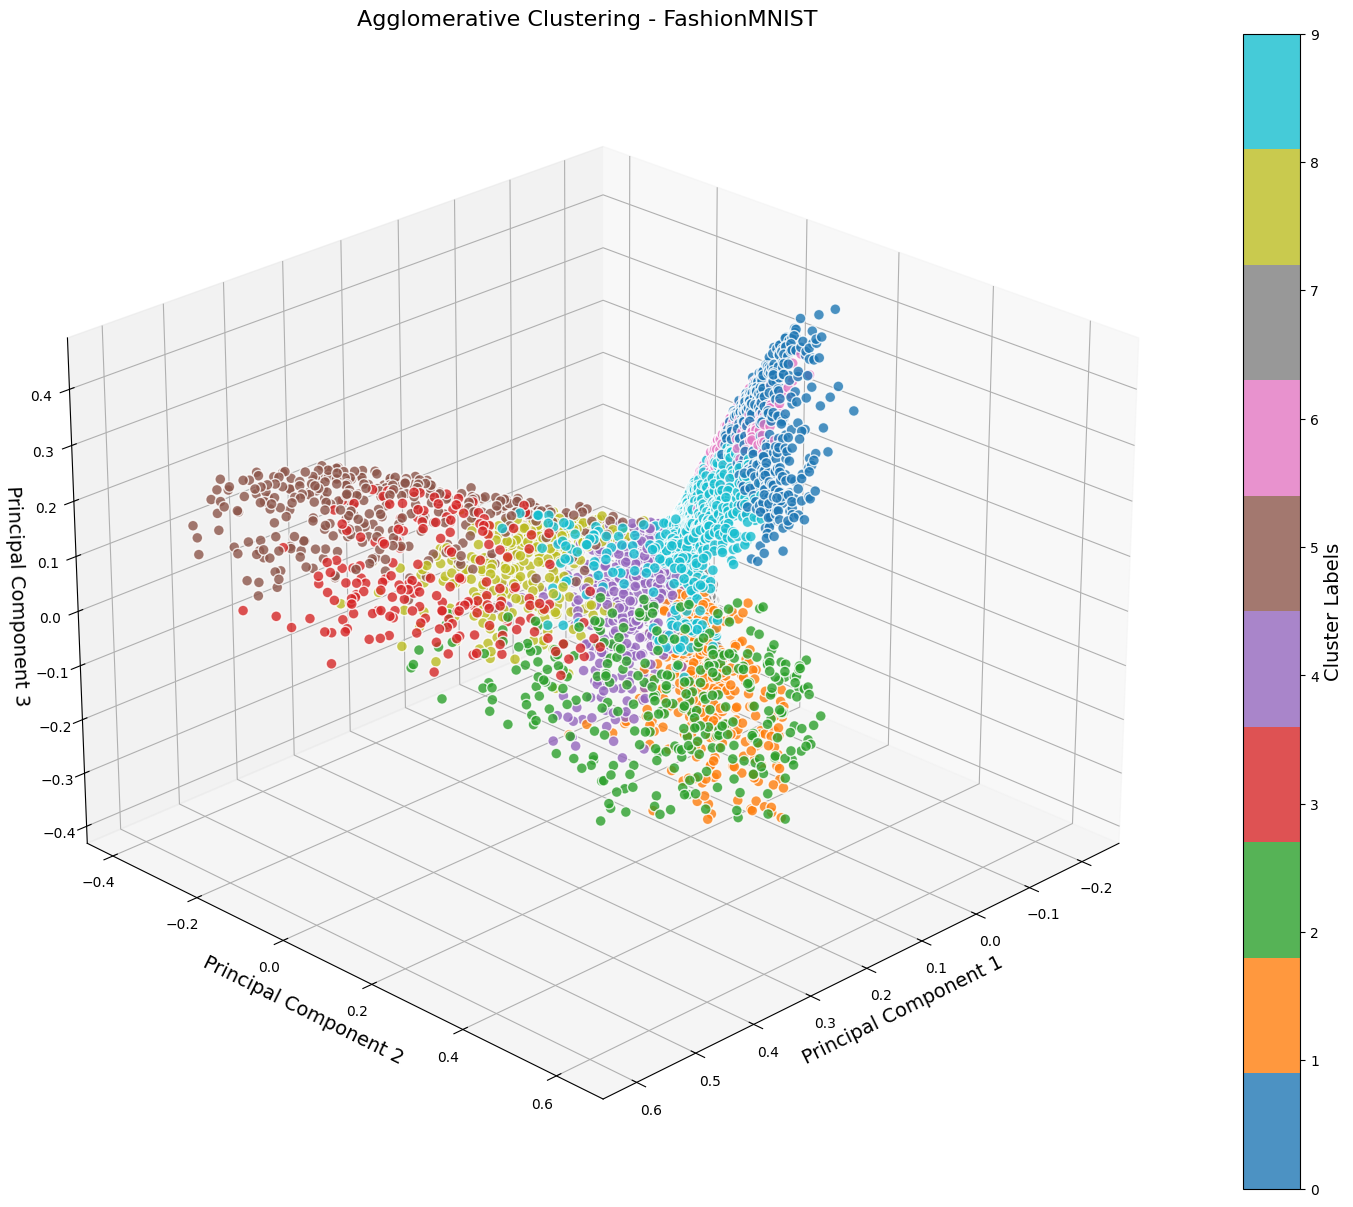

Silhouette score: 0.2917367219924927


In [228]:
# prompt: puoi provare a fare un altro metodo di raggruppamento?

from sklearn.cluster import AgglomerativeClustering

# Apply Agglomerative Clustering
agg_clustering = AgglomerativeClustering(n_clusters=10)  # Set the number of clusters
cluster_labels = agg_clustering.fit_predict(principal_components_gaussian)


# Example visualization (2D):
plt.figure(figsize=(8, 6))
plt.scatter(principal_components_gaussian[:, 0], principal_components_gaussian[:, 1], c=cluster_labels, cmap='viridis')  # Use cluster labels for colors
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Agglomerative Clustering of FashionMNIST (first 2 components)')
plt.colorbar()
plt.show()

# Example visualization (3D, if you used 3 principal components initially):
fig = plt.figure(figsize=(20, 15))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(
    principal_components_gaussian[:, 0],
    principal_components_gaussian[:, 1],
    principal_components_gaussian[:, 2],
    c=cluster_labels, cmap='tab10', s=60, alpha=0.8, edgecolors='w', marker='o'
)

ax.set_xlabel('Principal Component 1', fontsize=14)
ax.set_ylabel('Principal Component 2', fontsize=14)
ax.set_zlabel('Principal Component 3', fontsize=14)
ax.set_title('Agglomerative Clustering - FashionMNIST', fontsize=16)

colorbar = plt.colorbar(scatter, ax=ax, ticks=np.arange(10)) # Adjust ticks if n_clusters != 10
colorbar.set_label('Cluster Labels', fontsize=14)

ax.view_init(elev=25, azim=45)
plt.show()


# Evaluate clustering performance using silhouette score
silhouette_avg = silhouette_score(principal_components_gaussian, cluster_labels)
print(f"Silhouette score: {silhouette_avg}")


In [229]:
# Perform K-means clustering on the 10-dimensional data
kmeans = KMeans(n_clusters=10, random_state=42)
kmeans_labels = kmeans.fit_predict(principal_components_gaussian)

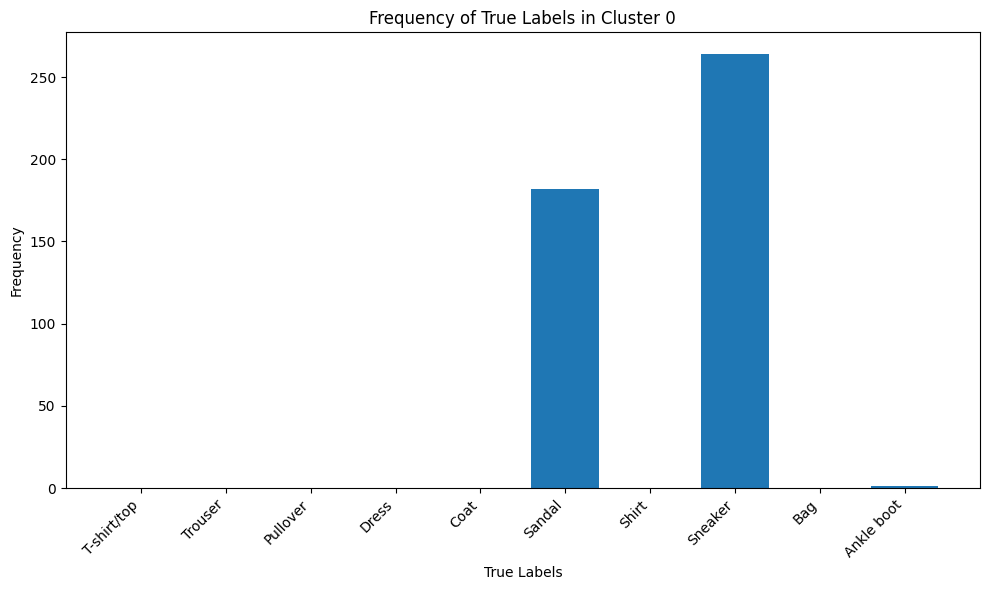

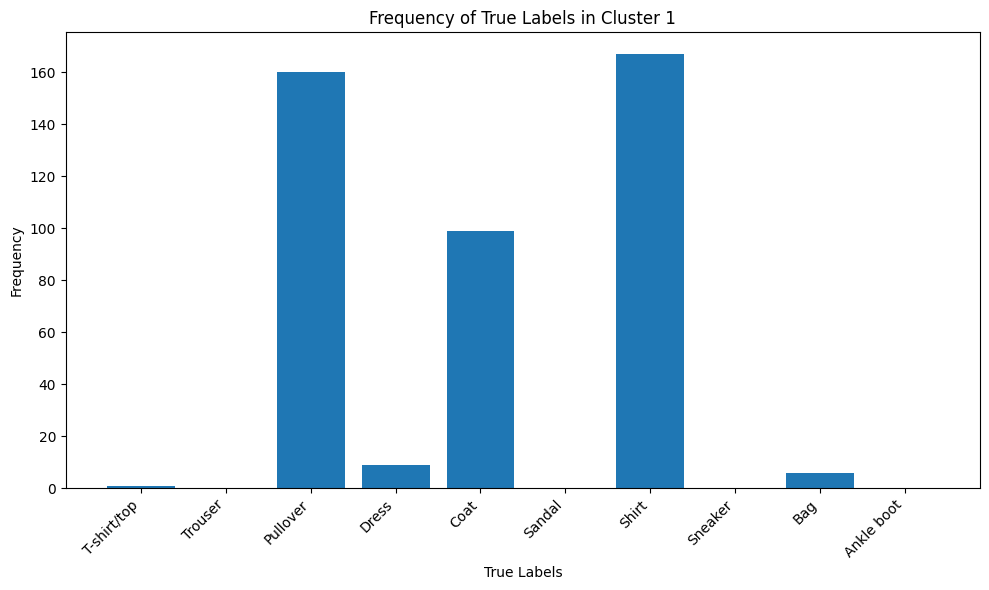

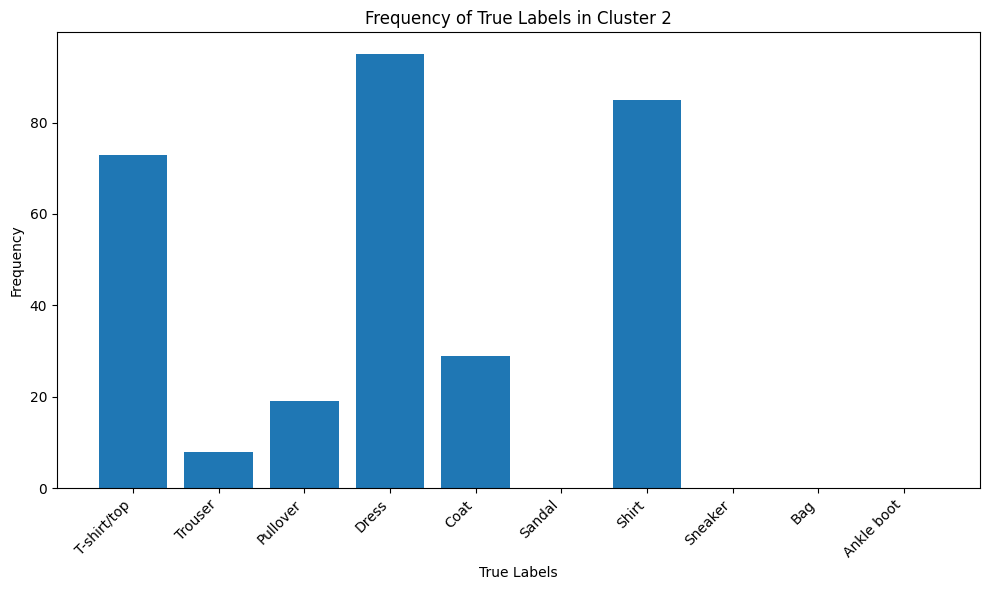

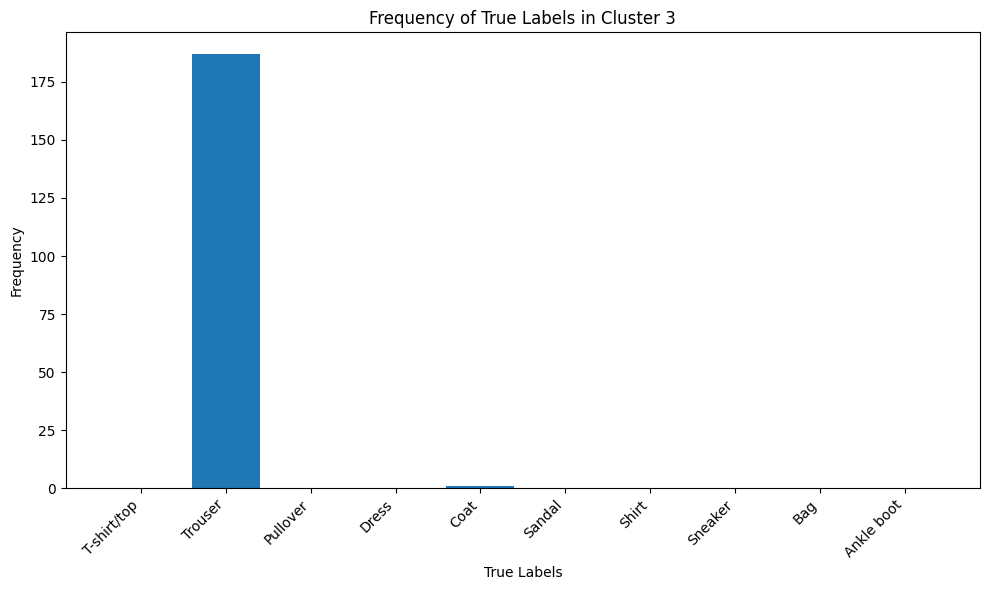

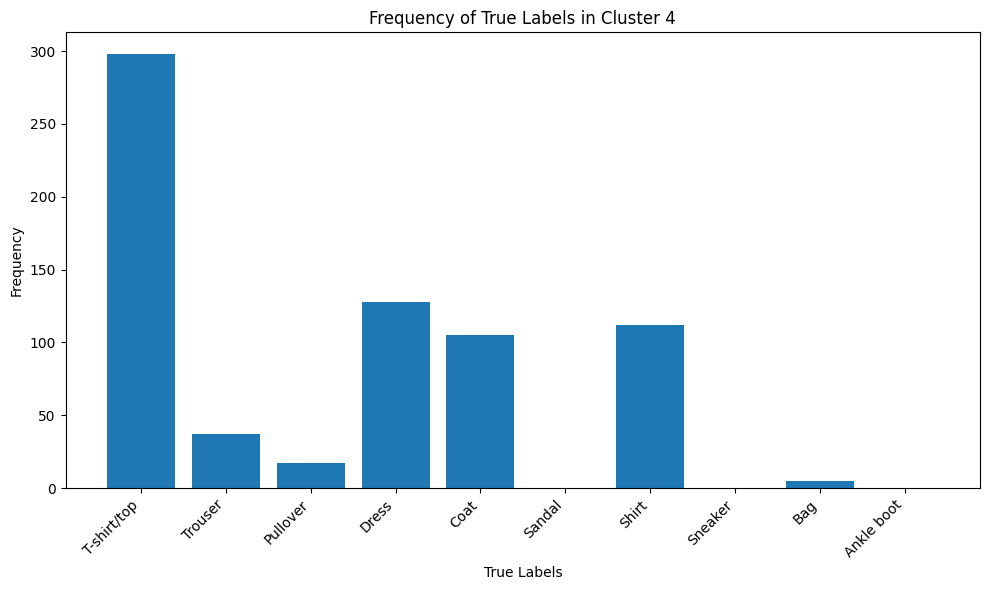

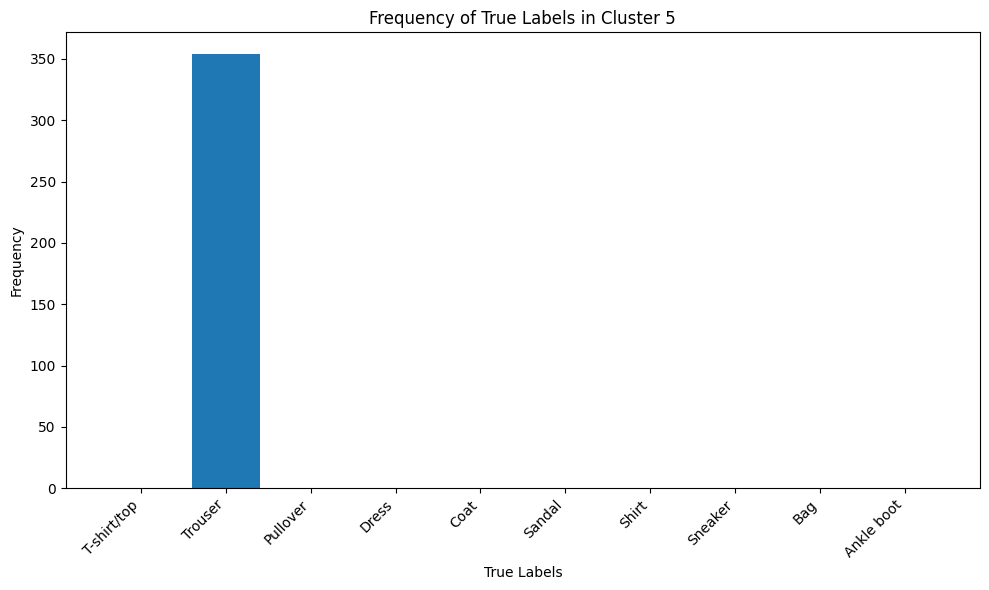

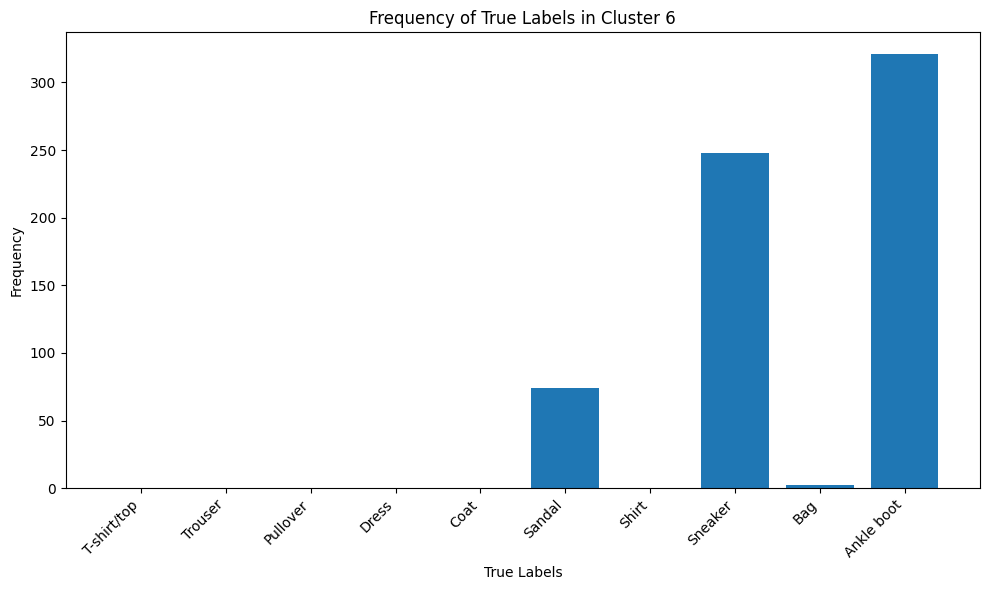

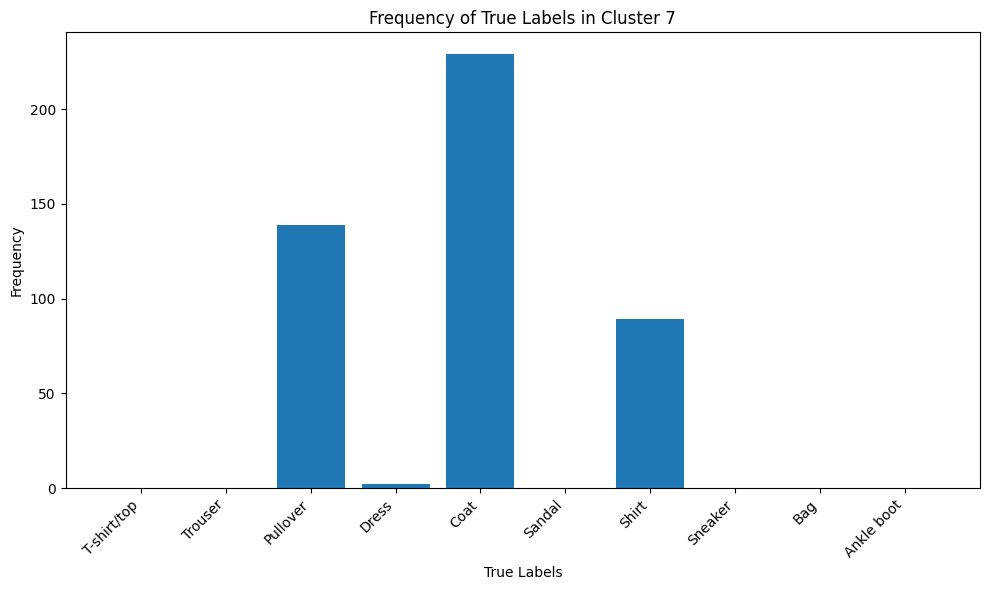

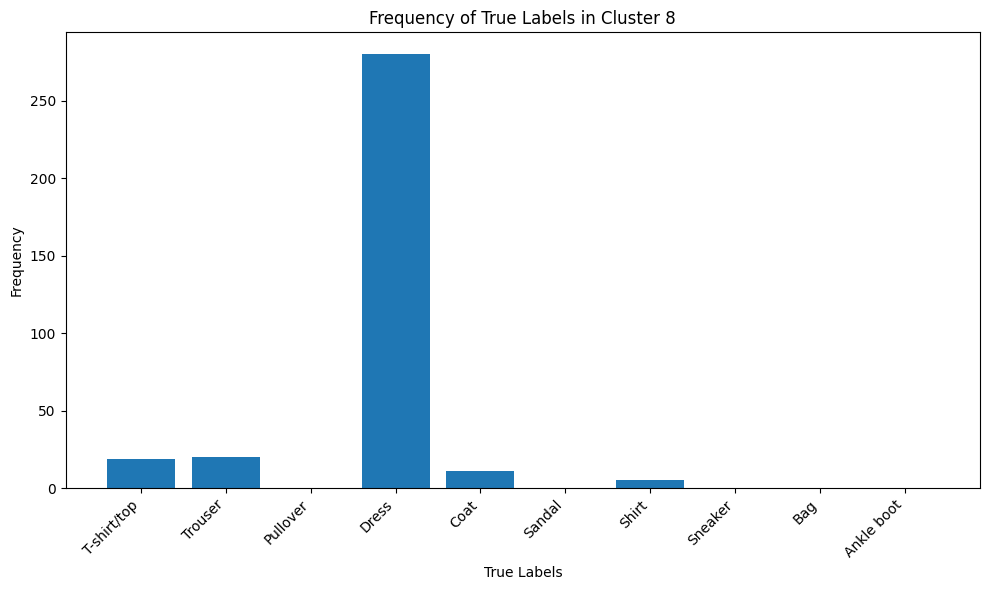

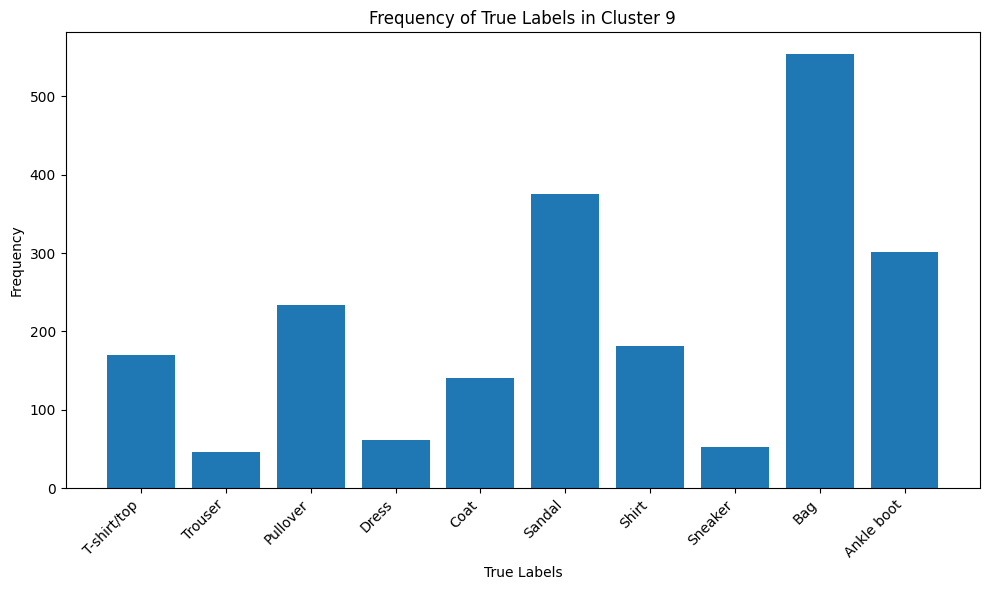

In [230]:
import matplotlib.pyplot as plt


# Create a dictionary to map numeric labels to class names
labels_dict = {
    0: 'T-shirt/top',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle boot'
}

# Iterate through each cluster
for cluster_label in range(10):
    # Find data points belonging to the current cluster
    cluster_indices = np.where(cluster_labels == cluster_label)[0]
    cluster_data = principal_components_gaussian[cluster_indices]
    cluster_true_labels = labels[cluster_indices]

    # Count the frequency of each true label within the cluster
    label_counts = np.bincount(cluster_true_labels, minlength=10)  # Adjust minlength if needed

    # Create a bar plot for the current cluster
    plt.figure(figsize=(10, 6))
    plt.bar(range(10), label_counts)
    plt.xticks(range(10), [labels_dict[i] for i in range(10)], rotation=45, ha='right')  # Use labels_dict
    plt.xlabel('True Labels')
    plt.ylabel('Frequency')
    plt.title(f'Frequency of True Labels in Cluster {cluster_label}')
    plt.tight_layout()
    plt.show()

In [114]:
import numpy as np
import matplotlib.pyplot as plt

def plot_Spectrum_and_CVR(kpca_eigenvalues, n_components_plot=None):
    # Se non viene specificato n_components_plot, prendiamo tutti i componenti
    if not n_components_plot:
        n_components_plot = kpca_eigenvalues.shape[0]

    fig, ax1 = plt.subplots(figsize=(9, 5))
    ax1.grid(zorder=1)

    # Spettro degli autovalori (eigenvalues)
    ax1.plot(range(1, n_components_plot+1), kpca_eigenvalues[:n_components_plot],
             color='darkred', linestyle='--', linewidth=1, zorder=2)
    ax1.axvline(x=10, color='r', linestyle='--', linewidth=2)
    ax1.scatter(range(1, n_components_plot+1), kpca_eigenvalues[:n_components_plot],
                label='Eigenvalues', s=30, color='indianred', edgecolors='black', zorder=2)
    ax1.set_xlabel('Eigenvalue Rank', fontsize=11)
    ax1.set_ylabel('Eigenvalues', color='darkred', fontsize=11)
    ax1.tick_params(axis='y', labelcolor='darkred')

    if n_components_plot:
        ax1.set_title(f'Kernel PCA Spectrum and Cumulative Explained Variance (zoom on first {n_components_plot} PCs)')
    else:
        ax1.set_title('Kernel PCA Spectrum and Cumulative Explained Variance')

    # Cumulative Variance Explained
    ax2 = ax1.twinx()  # Creiamo un secondo asse y
    explained_variance_ratio = np.cumsum(kpca_eigenvalues) / np.sum(kpca_eigenvalues)
    ax2.plot(range(1, n_components_plot+1), explained_variance_ratio[:n_components_plot],
             label='Cumulative Explained Variance', linestyle='--', color='navy', linewidth=1, zorder=2)
    ax2.set_ylabel('Cumulative Explained Variance Ratio', color='navy', labelpad=10, fontsize=11)
    ax2.tick_params(axis='y', labelcolor='navy')

    # Layout per evitare sovrapposizioni
    fig.tight_layout()

    return fig


In [115]:
# Traccia il grafico con i primi 5 componenti principali
kpca_gaussian100 = KernelPCA(n_components=100, kernel='rbf', gamma=0.005, fit_inverse_transform=True)
principal_components_gaussian100 = kpca_gaussian100.fit_transform(images_scaled)

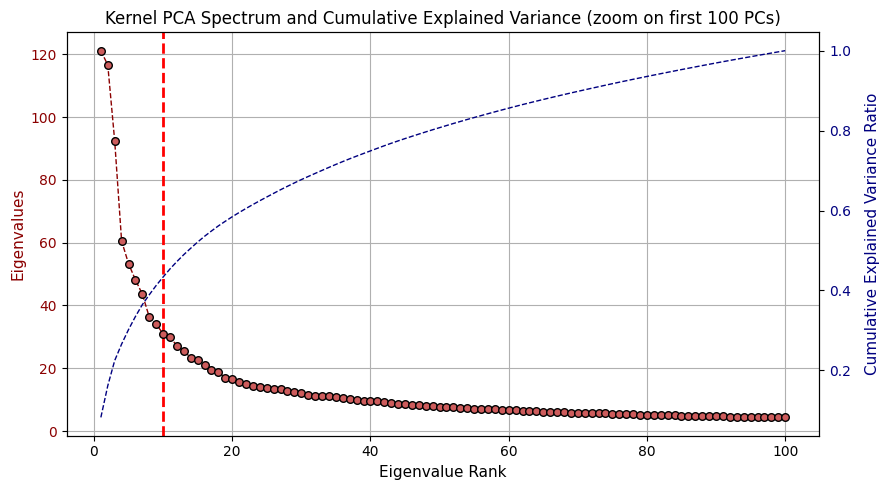

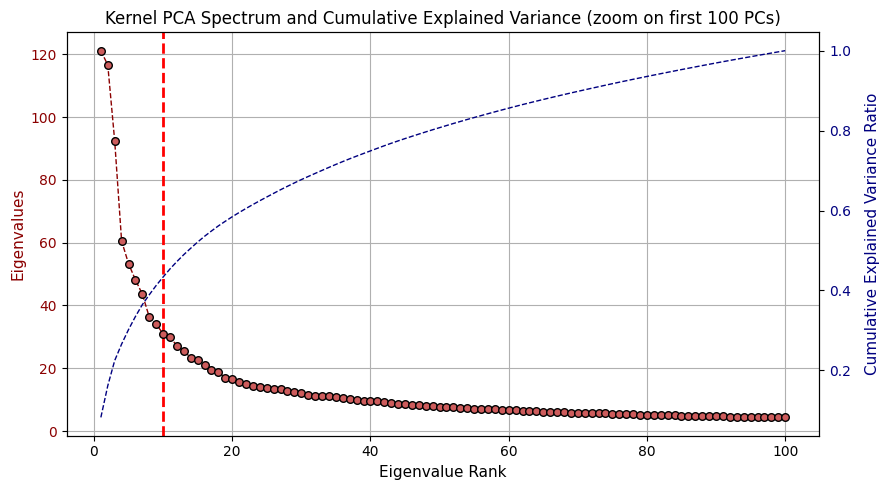

In [116]:
kpca_eigenvalues = kpca_gaussian100.eigenvalues_
plot_Spectrum_and_CVR(kpca_eigenvalues, n_components_plot=100)

### Section 3: (Supervised) classification

Consider the dataset composed of the original images, with the label assigned in the previous section (regardless of its actual match with the true label!). Then, define and learn a classifier that can predict the label of a new image. Specifically:

1. Learn a *kernel-SVM* on the data/label pairs. The choice of the kernel and its hyperparameters is up to your experimentation and time availability. Comment on your choices and results.

2. Learn a *fully-connected NN* on the data/label pairs. The choice of the architecture and its hyperparameters is up to your experimentation and time availability: show at least two different hyperparameter configurations, and comment on the results.

3. Learn a *CNN* on the data/label pairs. The choice of the architecture and its hyperparameters is up to your experimentation and time availability. Comment on the results with special respect to the FCN architecture.

In [231]:
X_train, X_test, y_train, y_test = train_test_split(images_scaled, kmeans_labels, test_size=0.2, random_state=42)
svm_classifier = SVC(kernel='rbf', C=10, gamma=0.005)

# Train the SVM classifier
svm_classifier.fit(X_train, y_train)

# Evaluate the classifier on the test set
accuracy = svm_classifier.score(X_test, y_test)
print(f'Accuracy of Kernel-SVM classifier: {accuracy}')

Accuracy of Kernel-SVM classifier: 0.94


Accuracy of Kernel-SVM classifier: 0.9400


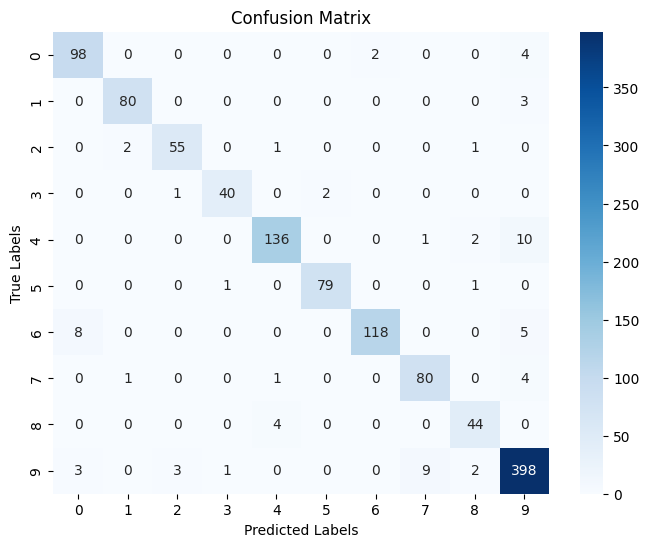

Precision: 0.9410
Recall: 0.9400
F1-Score: 0.9401

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.94      0.92       104
           1       0.96      0.96      0.96        83
           2       0.93      0.93      0.93        59
           3       0.95      0.93      0.94        43
           4       0.96      0.91      0.93       149
           5       0.98      0.98      0.98        81
           6       0.98      0.90      0.94       131
           7       0.89      0.93      0.91        86
           8       0.88      0.92      0.90        48
           9       0.94      0.96      0.95       416

    accuracy                           0.94      1200
   macro avg       0.94      0.94      0.94      1200
weighted avg       0.94      0.94      0.94      1200



In [232]:


# Evaluate the classifier on the test set
y_pred = svm_classifier.predict(X_test)

# Compute the accuracy (already done)
accuracy = svm_classifier.score(X_test, y_test)
print(f'Accuracy of Kernel-SVM classifier: {accuracy:.4f}')

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(len(set(y_test))), yticklabels=range(len(set(y_test))))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Precision, Recall, and F1-Score
precision = precision_score(y_test, y_pred, average='weighted')  # 'weighted' to account for class imbalance
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-Score: {f1:.4f}')

# Detailed classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# You could also plot the ROC curve if you have a binary classification (or per-class ROC in multi-class)


In [233]:
# prompt: Learn a fully-connected NN on the data/label pairs. The choice of the architecture and its hyperparameters is up to your experimentation and time availability: show at least two different hyperparameter configurations, and comment on the results

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Assuming X_train, X_test, y_train, y_test are your data and labels from the previous section

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Create DataLoader for training data
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)


# Define a fully connected neural network
class FCN(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, num_classes):
        super(FCN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_size2, num_classes)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.fc2(out)
        out = self.relu2(out)
        out = self.fc3(out)
        return out

# Hyperparameter configuration 1
input_size = X_train.shape[1]
hidden_size1 = 128
hidden_size2 = 64
num_classes = 10  # Assuming 10 classes
learning_rate = 0.001
num_epochs = 10

model1 = FCN(input_size, hidden_size1, hidden_size2, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model1.parameters(), lr=learning_rate)

# Training loop
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        outputs = model1(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Evaluate the model on the test set
with torch.no_grad():
    outputs = model1(X_test_tensor)
    _, predicted = torch.max(outputs.data, 1)
    accuracy = (predicted == y_test_tensor).sum().item() / len(y_test_tensor)
    print(f'Accuracy of FCN (Configuration 1): {accuracy:.4f}')


# Hyperparameter configuration 2 (e.g., different hidden layer sizes, learning rate)
hidden_size1 = 256
hidden_size2 = 128
learning_rate = 0.0005
num_epochs = 15

model2 = FCN(input_size, hidden_size1, hidden_size2, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model2.parameters(), lr=learning_rate)

# Training loop
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        outputs = model2(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Evaluate the model on the test set
with torch.no_grad():
    outputs = model2(X_test_tensor)
    _, predicted = torch.max(outputs.data, 1)
    accuracy = (predicted == y_test_tensor).sum().item() / len(y_test_tensor)
    print(f'Accuracy of FCN (Configuration 2): {accuracy:.4f}')



Epoch [1/10], Loss: 0.4409
Epoch [2/10], Loss: 0.3312
Epoch [3/10], Loss: 0.1592
Epoch [4/10], Loss: 0.2214
Epoch [5/10], Loss: 0.1106
Epoch [6/10], Loss: 0.1336
Epoch [7/10], Loss: 0.1011
Epoch [8/10], Loss: 0.0673
Epoch [9/10], Loss: 0.1146
Epoch [10/10], Loss: 0.0722
Accuracy of FCN (Configuration 1): 0.8817
Epoch [1/15], Loss: 0.2918
Epoch [2/15], Loss: 0.3365
Epoch [3/15], Loss: 0.3748
Epoch [4/15], Loss: 0.1777
Epoch [5/15], Loss: 0.1201
Epoch [6/15], Loss: 0.1191
Epoch [7/15], Loss: 0.0503
Epoch [8/15], Loss: 0.1256
Epoch [9/15], Loss: 0.1241
Epoch [10/15], Loss: 0.0363
Epoch [11/15], Loss: 0.0276
Epoch [12/15], Loss: 0.0734
Epoch [13/15], Loss: 0.0303
Epoch [14/15], Loss: 0.0777
Epoch [15/15], Loss: 0.0145
Accuracy of FCN (Configuration 2): 0.9017


In [234]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Aggiungi il canale (1, 28, 28) per le immagini
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).unsqueeze(1)  # Aggiungi il canale
y_train_tensor = torch.tensor(y_train, dtype=torch.long)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32).unsqueeze(1)  # Aggiungi il canale
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Crea un DataLoader per i dati di addestramento
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Definisci un modello CNN
class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)  # Primo layer convoluzionale (1 canale di input, 16 canali di output)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2, 2)  # Max pooling con stride 2 e kernel 2x2

        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)  # Secondo layer convoluzionale (16 canali di input, 32 canali di output)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2, 2)  # Max pooling con stride 2 e kernel 2x2

        self.fc1 = nn.Linear(32 * 7 * 7, 128)  # Fully connected layer (32 canali * 7 * 7 dimensioni spaziali dopo il pooling)
        self.fc2 = nn.Linear(128, num_classes)  # Output layer (10 classi)

    def forward(self, x):
        x = self.conv1(x)  # Passaggio attraverso il primo layer convoluzionale
        x = self.relu1(x)   # Funzione di attivazione ReLU
        x = self.pool1(x)   # Max pooling

        x = self.conv2(x)  # Passaggio attraverso il secondo layer convoluzionale
        x = self.relu2(x)   # Funzione di attivazione ReLU
        x = self.pool2(x)   # Max pooling

        x = x.view(-1, 32 * 7 * 7)  # Appiattimento (flatten) per il fully connected
        x = self.fc1(x)   # Passaggio attraverso il primo layer completamente connesso
        x = self.fc2(x)   # Passaggio attraverso il secondo layer (output)
        return x

# Definisci il modello e gli altri parametri
model = CNN(num_classes=10)

# Configura la funzione di perdita e l'ottimizzatore
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Modifica il ciclo di addestramento e il ciclo di test per adattarsi alla CNN
for epoch in range(num_epochs):
    model.train()
    for i, (images, labels) in enumerate(train_loader):
        images = images.view(-1, 1, 28, 28)  # Modifica la forma dell'input per avere [batch_size, 1, 28, 28]

        outputs = model(images)  # Passaggio attraverso la CNN
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Valutazione del modello sul test set
model.eval()
with torch.no_grad():
    X_test_tensor = X_test_tensor.view(-1, 1, 28, 28)  # Modifica la forma dell'input di test
    outputs = model(X_test_tensor)
    _, predicted = torch.max(outputs.data, 1)
    accuracy = (predicted == y_test_tensor).sum().item() / len(y_test_tensor)
    print(f'Accuracy of CNN: {accuracy:.4f}')


Epoch [1/15], Loss: 0.2937
Epoch [2/15], Loss: 0.1354
Epoch [3/15], Loss: 0.3690
Epoch [4/15], Loss: 0.3142
Epoch [5/15], Loss: 0.2595
Epoch [6/15], Loss: 0.0479
Epoch [7/15], Loss: 0.2296
Epoch [8/15], Loss: 0.1262
Epoch [9/15], Loss: 0.2595
Epoch [10/15], Loss: 0.2815
Epoch [11/15], Loss: 0.2363
Epoch [12/15], Loss: 0.0933
Epoch [13/15], Loss: 0.1234
Epoch [14/15], Loss: 0.1348
Epoch [15/15], Loss: 0.0535
Accuracy of CNN: 0.8892


### Section 4: Wrap-up!

Evaluate the overall accuracy of the pipeline on the *test set* of *FashionMNIST*. *I.e.* compare the predicted labels from the three classifiers built in *Section 3* with the true labels.

In order to assign a true label *name* (e.g. *trousers*, *sandal*, ...) to those determined just from *(kernel-)PCA* (that obviously carry no direct information about the subject of the picture), you can either:

i. *Cheat* and use the most abundant labels for each group of *(kernel-)PCA-labelled* datapoints.

ii. Sample a subset of datapoints from each *(kernel-)PCA-labelled* class, and assign one label by direct visual inspection. If you choose this route, it may also serve as a reminder of the fact that *expert labelling* is not always a trivial (and almost never a fast) task!

Comment on the results obtained.

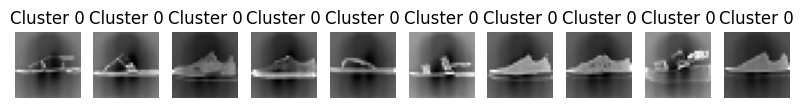

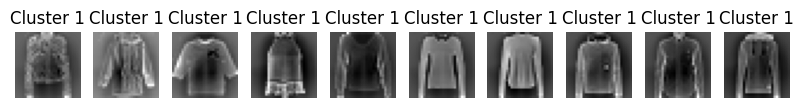

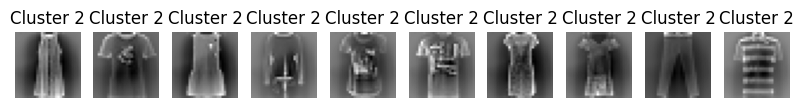

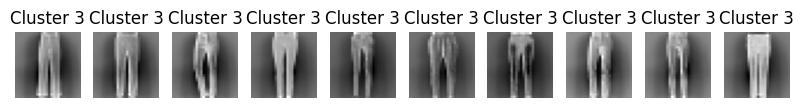

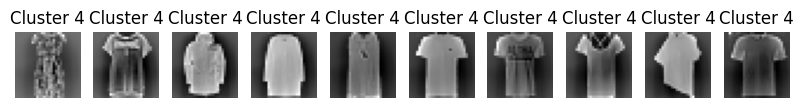

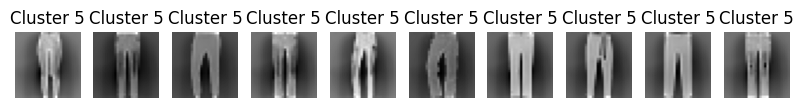

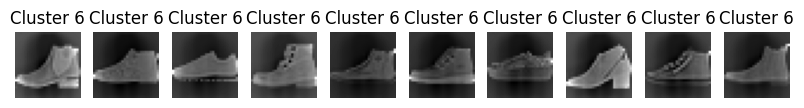

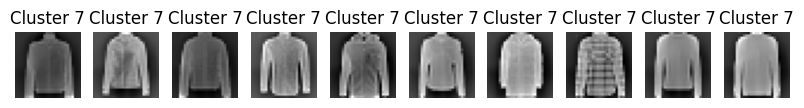

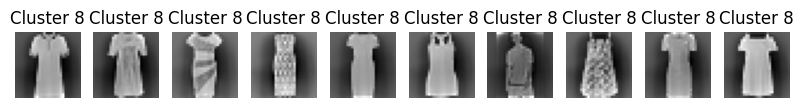

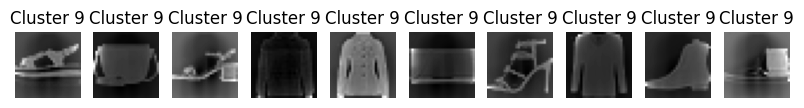

In [264]:
import matplotlib.pyplot as plt

# Visualize images from each cluster
unique_labels = np.unique(cluster_labels)

# Number of clusters
n_clusters = len(unique_labels)

# Plot a few images from each cluster
for cluster in unique_labels:
    cluster_indices = np.where(cluster_labels == cluster)[0]
    plt.figure(figsize=(10, 5))

    # Take the first 5 images from each cluster (you can choose more)
    for i, idx in enumerate(cluster_indices[:10]):
        plt.subplot(1, 10, i + 1)
        img = images_scaled[idx].reshape(28, 28)
        plt.imshow(img, cmap='gray')
        plt.axis('off')
        plt.title(f"Cluster {cluster}")

    plt.show()
    # This is where you visually inspect the images and assign a label manually
    # Based on the inspection, assign a label to the current cluster
    # Example: If cluster 0 looks like T-shirts, assign the label 'T-shirt' to this cluster


In [265]:
cluster_to_true_label = {
    0: 'Sneaker',       # Cluster 0 looks like T-shirts
    1: 'Pullover',           # Cluster 1 looks like trousers
    2: 'Shirt',          # Cluster 2 looks like pullovers
    3: 'Coat',             # Cluster 3 looks like dresses
    4: 'T-shirt/top',              # Cluster 4 looks like coats
    5: 'Trouser',            # Cluster 5 looks like sandals
    6: 'Ankle boot',             # Cluster 6 looks like shirts
    7: 'Bag',           # Cluster 7 looks like sneakers
    8: 'Dress',               # Cluster 8 looks like bags
    9: 'Sandal'         # Cluster 9 looks like ankle boots
}

# labels_dict = { 0: 'T-shirt/top',
#                 1: 'Trouser',
#                 2: 'Pullover',
#                 3: 'Dress',
#                 4: 'Coat',
#                 5: 'Sandal',
#                 6: 'Shirt',
#                 7: 'Sneaker',
#                 8: 'Bag',
#                 9: 'Ankle boot' }

In [247]:
prediction_svm = svm_classifier.predict(images_scaled_test)
print(prediction_svm)

[5 9 4 ... 4 4 6]


In [248]:
# Rimodella le immagini in modo che abbiano la forma [batch_size, 1, 28, 28]
images_test = images_scaled_test.reshape(-1, 1, 28, 28)
# Converti le immagini in un tensor PyTorch
images_test_tensor = torch.tensor(images_test, dtype=torch.float32)
labels_test_tensor = torch.tensor(labels_test, dtype=torch.long)


In [249]:
# Imposta il modello in modalità di valutazione
model.eval()

# Lista per memorizzare le predizioni
all_predictions_cnn = []

# Usa torch.no_grad() per disabilitare il calcolo dei gradienti (solo per inferenza)
with torch.no_grad():
    # Passa le immagini attraverso il modello
    outputs = model(images_test_tensor)

    # Ottieni le classi predette prendendo l'indice con il valore massimo
    _, predicted = torch.max(outputs, 1)  # '1' indica la dimensione delle colonne (le classi)

    # Memorizza le predizioni
    all_predictions_cnn.extend(predicted.cpu().numpy())  # Aggiungi alla lista di predizioni

# Visualizza le prime 10 predizioni
print(all_predictions_cnn[:10])


[5, 9, 4, 6, 9, 9, 9, 6, 9, 8]


In [250]:
# Assicurati che le immagini siano appiattite da [batch_size, 1, 28, 28] a [batch_size, 784]
input_tensor = images_test_tensor.view(images_test_tensor.size(0), -1)  # appiattisce le immagini


In [251]:
# Imposta il modello in modalità di valutazione
model1.eval()

# Lista per memorizzare le predizioni
all_predictions_fcn = []

# Usa torch.no_grad() per disabilitare il calcolo dei gradienti (solo per inferenza)
with torch.no_grad():
    # Passa le immagini attraverso il modello
    outputs = model1(input_tensor)

    # Ottieni le classi predette prendendo l'indice con il valore massimo
    _, predicted = torch.max(outputs, 1)  # '1' indica la dimensione delle colonne (le classi)

    # Memorizza le predizioni
    all_predictions_fcn.extend(predicted.cpu().numpy())  # Aggiungi alla lista di predizioni

# Visualizza le prime 10 predizioni
print(all_predictions_fcn[:10])


[5, 9, 4, 6, 9, 9, 9, 6, 9, 8]


In [266]:
predictions_fcn_mapped = [cluster_to_true_label[label] for label in all_predictions_fcn]
predictions_cnn_mapped = [cluster_to_true_label[label] for label in all_predictions_cnn]
predicted_labels_names = [cluster_to_true_label[label] for label in prediction_svm]

Accuracy of the SVM prediction on the test set: 0.359


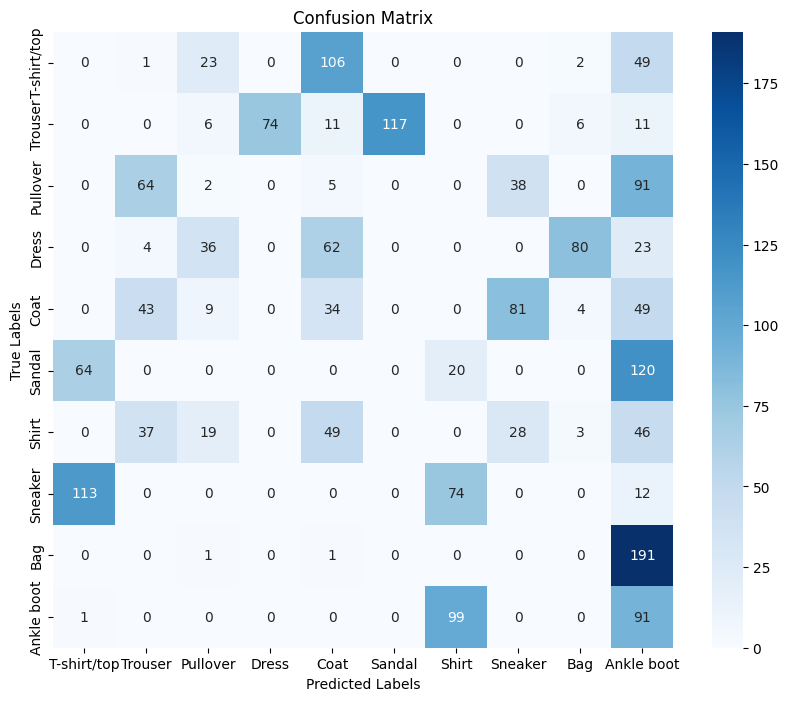

In [269]:
# Now compare with the true labels
accuracy = np.mean(np.array(predicted_labels_names) == np.array([labels_dict[label] for label in labels_test]))
print(f"Accuracy of the SVM prediction on the test set: {accuracy}")

# You can further analyze the results using a confusion matrix or other metrics.
cm = confusion_matrix(labels_test, prediction_svm)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=list(labels_dict.values()), yticklabels=list(labels_dict.values()))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

Accuracy of the FCN prediction on the test set: 0.359


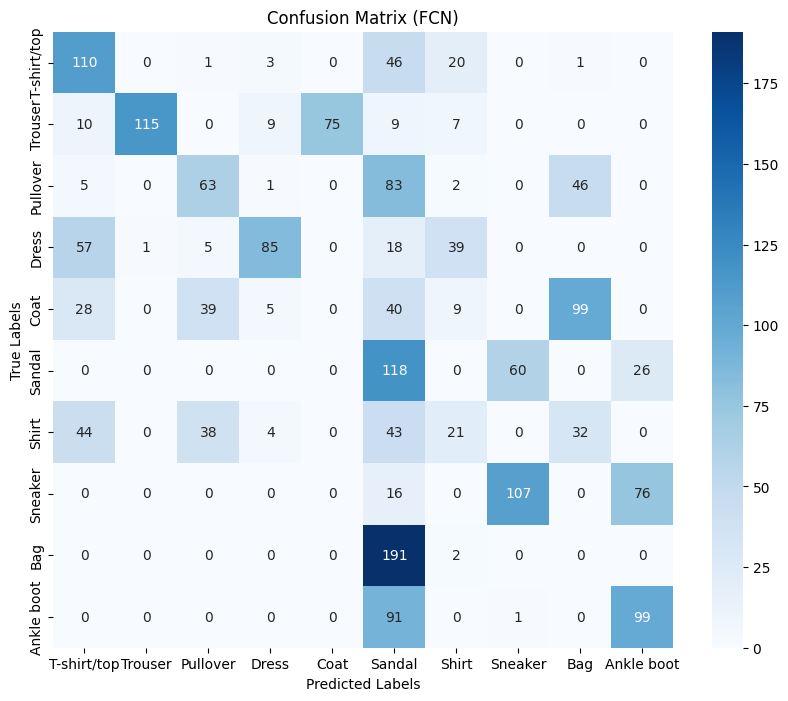

Accuracy of the CNN prediction on the test set: 0.3515


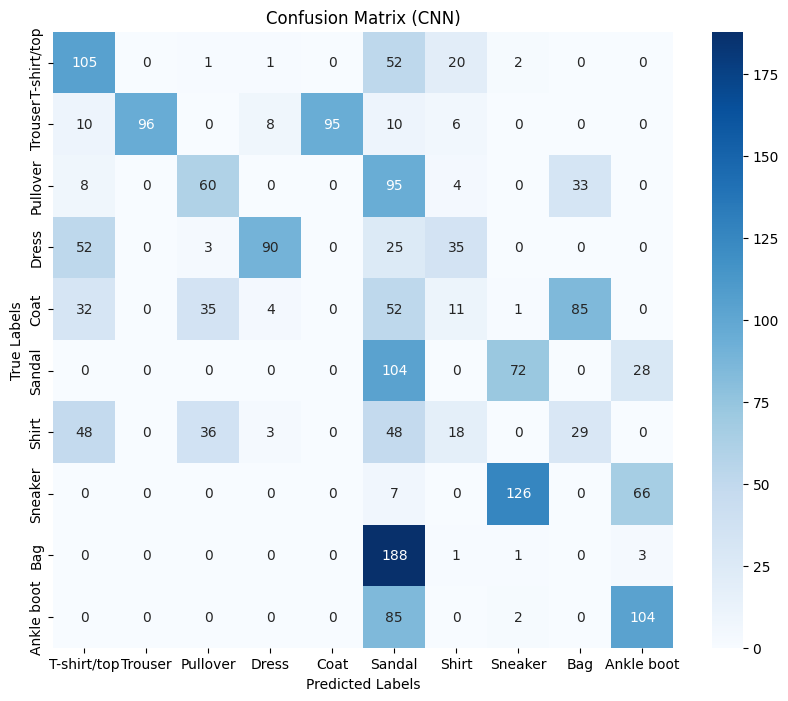

In [268]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Convert numerical labels_test to string labels
true_labels_names = [labels_dict[label] for label in labels_test]


# Compare FCN predictions with true labels
accuracy_fcn = np.mean(np.array(predictions_fcn_mapped) == np.array(true_labels_names))
print(f"Accuracy of the FCN prediction on the test set: {accuracy_fcn}")

cm_fcn = confusion_matrix(true_labels_names, predictions_fcn_mapped, labels=list(labels_dict.values())) #Use all possible labels

plt.figure(figsize=(10, 8))
sns.heatmap(cm_fcn, annot=True, fmt='d', cmap='Blues', xticklabels=list(labels_dict.values()), yticklabels=list(labels_dict.values()))
plt.title('Confusion Matrix (FCN)')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


# Compare CNN predictions with true labels
accuracy_cnn = np.mean(np.array(predictions_cnn_mapped) == np.array(true_labels_names))
print(f"Accuracy of the CNN prediction on the test set: {accuracy_cnn}")


cm_cnn = confusion_matrix(true_labels_names, predictions_cnn_mapped, labels=list(labels_dict.values()))
plt.figure(figsize=(10, 8))
sns.heatmap(cm_cnn, annot=True, fmt='d', cmap='Blues', xticklabels=list(labels_dict.values()), yticklabels=list(labels_dict.values()))
plt.title('Confusion Matrix (CNN)')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

### Section 5: A *fully-supervised* approach

Repeat the steps of *Section 3* using the true labels of the dataset. Comment on the results, and draw a comparison between such results and those obtained from the previous *hybrid* pipeline.

In [275]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

# Assuming 'images' contains the image data and 'assigned_labels' contains the labels assigned in the previous section
X_train, X_test, y_train, y_test = train_test_split(images_scaled, labels, test_size=0.2, random_state=42)

# Choose a kernel and hyperparameters (experiment with different options)
svm_classifier = SVC(kernel='rbf', C=1.0, gamma='scale')  # Example: Radial Basis Function (RBF) kernel

# Train the SVM classifier
svm_classifier.fit(X_train, y_train)

# Evaluate the classifier on the test set
accuracy = svm_classifier.score(X_test, y_test)
print(f'Accuracy of Kernel-SVM classifier: {accuracy}')

Accuracy of Kernel-SVM classifier: 0.8416666666666667


Accuracy of Kernel-SVM classifier: 0.8417


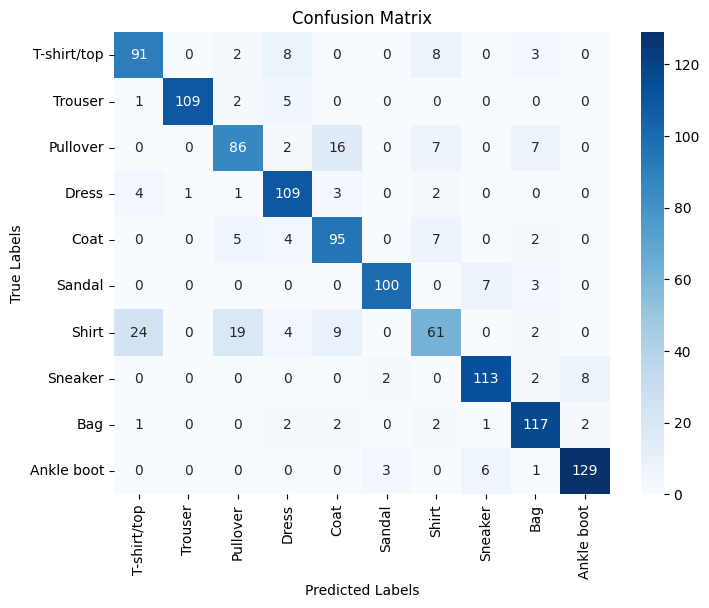

Precision: 0.8407
Recall: 0.8417
F1-Score: 0.8389

Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.81      0.78       112
           1       0.99      0.93      0.96       117
           2       0.75      0.73      0.74       118
           3       0.81      0.91      0.86       120
           4       0.76      0.84      0.80       113
           5       0.95      0.91      0.93       110
           6       0.70      0.51      0.59       119
           7       0.89      0.90      0.90       125
           8       0.85      0.92      0.89       127
           9       0.93      0.93      0.93       139

    accuracy                           0.84      1200
   macro avg       0.84      0.84      0.84      1200
weighted avg       0.84      0.84      0.84      1200



In [276]:
# Evaluate the classifier on the test set
y_pred = svm_classifier.predict(X_test)

# Compute the accuracy (already done)
accuracy = svm_classifier.score(X_test, y_test)
print(f'Accuracy of Kernel-SVM classifier: {accuracy:.4f}')

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=list(labels_dict.values()), yticklabels=list(labels_dict.values()))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Precision, Recall, and F1-Score
precision = precision_score(y_test, y_pred, average='weighted')  # 'weighted' to account for class imbalance
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-Score: {f1:.4f}')

# Detailed classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

In [259]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Assuming X_train, X_test, y_train, y_test are your data and labels from the previous section

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Create DataLoader for training data
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)


# Define a fully connected neural network
class FCN(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, num_classes):
        super(FCN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_size2, num_classes)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.fc2(out)
        out = self.relu2(out)
        out = self.fc3(out)
        return out

# Hyperparameter configuration 1
input_size = X_train.shape[1]
hidden_size1 = 128
hidden_size2 = 64
num_classes = 10  # Assuming 10 classes
learning_rate = 0.001
num_epochs = 10

model1 = FCN(input_size, hidden_size1, hidden_size2, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model1.parameters(), lr=learning_rate)

# Training loop
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        outputs = model1(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Evaluate the model on the test set
with torch.no_grad():
    outputs = model1(X_test_tensor)
    _, predicted = torch.max(outputs.data, 1)
    accuracy = (predicted == y_test_tensor).sum().item() / len(y_test_tensor)
    print(f'Accuracy of FCN (Configuration 1): {accuracy:.4f}')


# Hyperparameter configuration 2 (e.g., different hidden layer sizes, learning rate)
hidden_size1 = 256
hidden_size2 = 128
learning_rate = 0.0005
num_epochs = 15

model2 = FCN(input_size, hidden_size1, hidden_size2, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model2.parameters(), lr=learning_rate)

# Training loop
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        outputs = model2(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Evaluate the model on the test set
with torch.no_grad():
    outputs = model2(X_test_tensor)
    _, predicted = torch.max(outputs.data, 1)
    accuracy = (predicted == y_test_tensor).sum().item() / len(y_test_tensor)
    print(f'Accuracy of FCN (Configuration 2): {accuracy:.4f}')


Epoch [1/10], Loss: 0.4305
Epoch [2/10], Loss: 0.3342
Epoch [3/10], Loss: 0.3410
Epoch [4/10], Loss: 0.3349
Epoch [5/10], Loss: 0.3671
Epoch [6/10], Loss: 0.1272
Epoch [7/10], Loss: 0.3410
Epoch [8/10], Loss: 0.0746
Epoch [9/10], Loss: 0.0922
Epoch [10/10], Loss: 0.2218
Accuracy of FCN (Configuration 1): 0.8508
Epoch [1/15], Loss: 0.6158
Epoch [2/15], Loss: 0.5035
Epoch [3/15], Loss: 0.3853
Epoch [4/15], Loss: 0.2299
Epoch [5/15], Loss: 0.2045
Epoch [6/15], Loss: 0.1131
Epoch [7/15], Loss: 0.1095
Epoch [8/15], Loss: 0.2049
Epoch [9/15], Loss: 0.1586
Epoch [10/15], Loss: 0.0781
Epoch [11/15], Loss: 0.1375
Epoch [12/15], Loss: 0.1541
Epoch [13/15], Loss: 0.0951
Epoch [14/15], Loss: 0.0991
Epoch [15/15], Loss: 0.0193
Accuracy of FCN (Configuration 2): 0.8517


In [260]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
# Assuming X_train, X_test, y_train, y_test are your data and labels from the previous section
# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(np.array(X_train).reshape(-1, 1, 28, 28), dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(np.array(X_test).reshape(-1, 1, 28, 28), dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Create DataLoader for training data
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)


# Define a CNN model
class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(7 * 7 * 32, 128)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        out = self.conv1(x)
        out = self.relu1(out)
        out = self.maxpool1(out)
        out = self.conv2(out)
        out = self.relu2(out)
        out = self.maxpool2(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.relu3(out)
        out = self.fc2(out)
        return out


# Hyperparameter configuration
num_classes = 10
learning_rate = 0.001
num_epochs = 10

model = CNN(num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


# Training loop
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Evaluate the model on the test set
with torch.no_grad():
    outputs = model(X_test_tensor)
    _, predicted = torch.max(outputs.data, 1)
    accuracy = (predicted == y_test_tensor).sum().item() / len(y_test_tensor)
    print(f'Accuracy of CNN: {accuracy:.4f}')

Epoch [1/10], Loss: 0.5106
Epoch [2/10], Loss: 0.4505
Epoch [3/10], Loss: 0.6334
Epoch [4/10], Loss: 0.5704
Epoch [5/10], Loss: 0.4020
Epoch [6/10], Loss: 0.2618
Epoch [7/10], Loss: 0.2527
Epoch [8/10], Loss: 0.1135
Epoch [9/10], Loss: 0.4913
Epoch [10/10], Loss: 0.1344
Accuracy of CNN: 0.8708


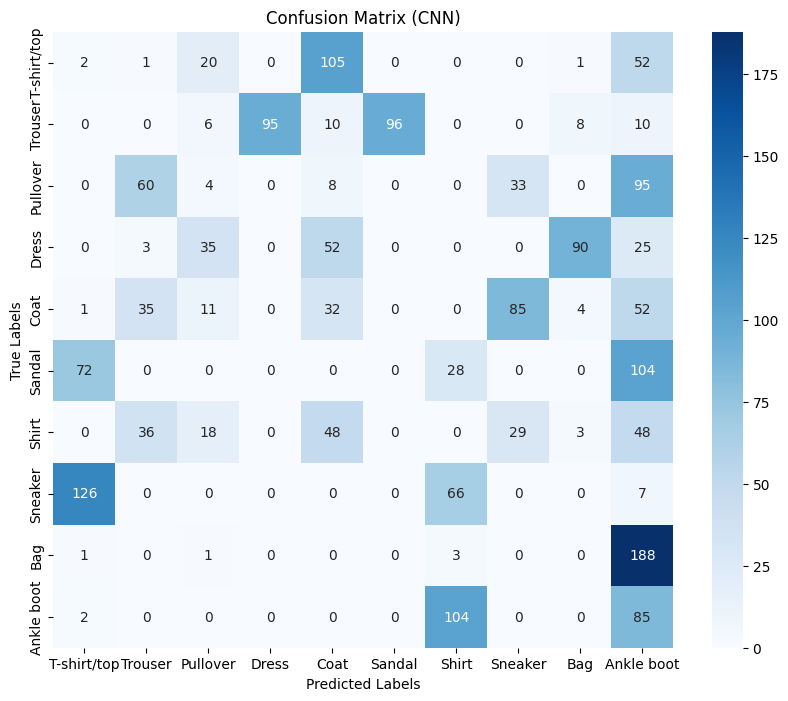

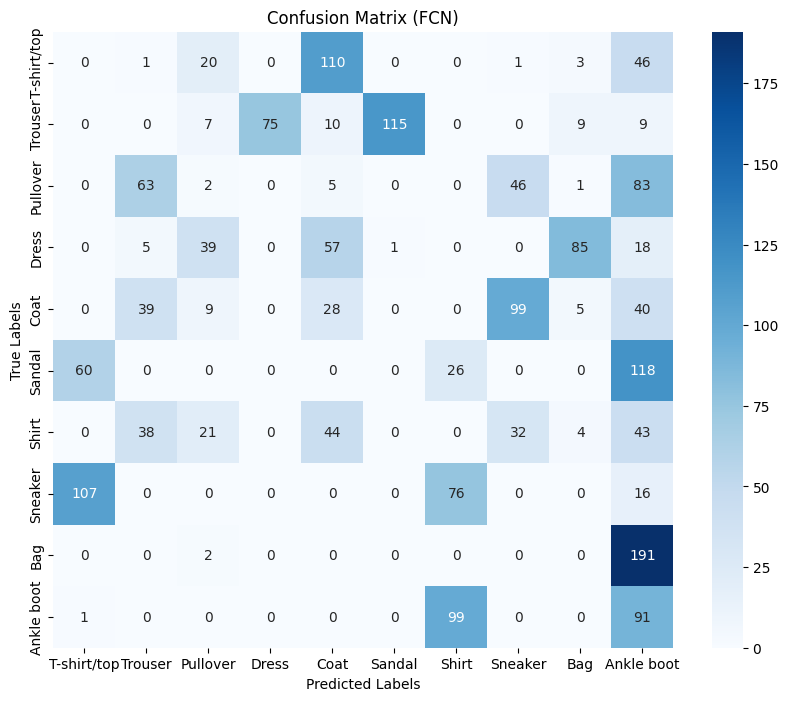

In [270]:
# prompt: puoi fare la confusion matrix di model, e model2? considera che sono una CNN e una FCNN

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'all_predictions_cnn', 'all_predictions_fcn', and 'labels_test' are defined as in your previous code

# Confusion Matrix for CNN
cm_cnn = confusion_matrix(labels_test, all_predictions_cnn)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_cnn, annot=True, fmt='d', cmap='Blues', xticklabels=list(labels_dict.values()), yticklabels=list(labels_dict.values()))
plt.title('Confusion Matrix (CNN)')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Confusion Matrix for FCN
cm_fcn = confusion_matrix(labels_test, all_predictions_fcn)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_fcn, annot=True, fmt='d', cmap='Blues', xticklabels=list(labels_dict.values()), yticklabels=list(labels_dict.values()))
plt.title('Confusion Matrix (FCN)')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


And please, avoid doing that... 👇🏻

![image.png](attachment:image.png)